# Demo - MATSim Population for West London

This notebook demonstrates an complex example workflow for creating a sample population for an area in West London. It creates agent plans for people and households using a random process.

## Aim
Create a bigger and more realistic sample population automatically for the West London area called Londinium. 
The sample population includes various activities, personal attributes and modes; the population would be used as input for MATSim transport simulation.

Steps:

1. [Import geographic data of Londinium;](#import-geographic-data-of-londinium)
2. [Facility sampling from OpenStreetMap data;](#facility-sampler)
2. [Activity generation model with home based tours. Expand agents with different personal attributes, activities and trips;](#activity-generation-model)
3. [Perform Data Visualization and validation. Plot the activity plan, distance and duration of population;](#data-visulazation-and-validation)
4. [Export intermediate CSV tables of the population](#readwrite-data)

In [1]:
import os

import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pam.activity import Activity, Leg
from pam.core import Household, Person, Population
from pam.plot.stats import plot_activity_times
from pam.read import load_travel_diary
from pam.report.benchmarks import distance_counts, duration_counts
from pam.samplers import facility
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY
from pam.write import to_csv, write_matsim, write_od_matrices

%matplotlib inline

## Import geographic data of Londinium

In [2]:
# Import geographic data of west london area
network_bb_path = os.path.join("data", "network_bounding_box.geojson")
lsoas_path = os.path.join("data", "lsoas")  # lsoas: lower layer super output areas

We will start by plotting Londinium boundary

<Axes: >

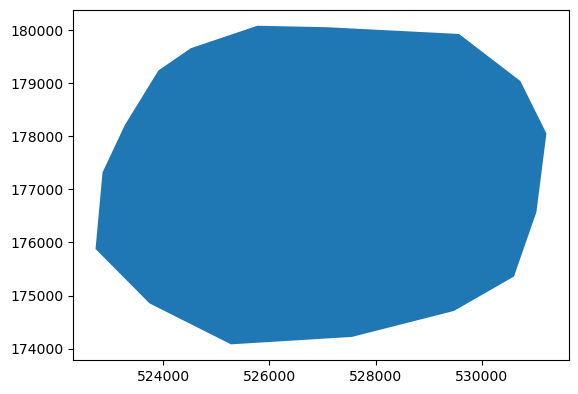

In [3]:
# Read the file and plot the boundary
boundary = gp.read_file(network_bb_path)

# Transform to epsg:27700
boundary = boundary.to_crs("epsg:27700")
boundary.plot()

Next we will plot Londinium outline shown above over a map of London to see where exactly it is located.

EPSG:27700


<Axes: >

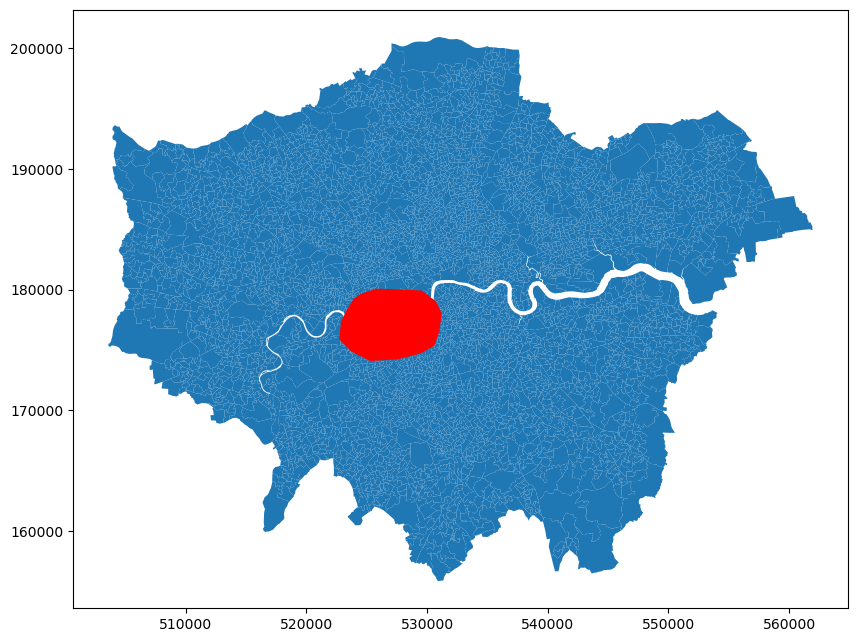

In [4]:
# Plot boundary area in lsoas
lsoas = gp.read_file(lsoas_path)
lsoas.crs = "EPSG:27700"
print(lsoas.crs)
lsoas = lsoas.set_index("LSOA_CODE")

fig, ax = plt.subplots(figsize=(10, 10))
lsoas.plot(ax=ax)
boundary.plot(ax=ax, color="red")

Finally, we will plot Londinium with LSOA boundaries included.

/Users/bryn.pickering/mambaforge/envs/pam/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


<Axes: >

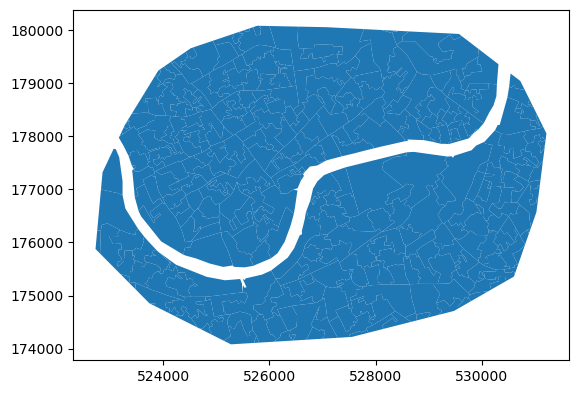

In [5]:
# Overlay the area using geopandas package
lsoas_clipped = gp.overlay(lsoas, boundary, how="intersection")
lsoas_clipped.plot()

In [6]:
lsoas_clipped.head()

,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry
0,Hammersmith and Fulham 010A,E02000381,Hammersmith and Fulham 010,00ANGA,Addison,00AN,Hammersmith and Fulham,"POLYGON ((523932.247 179242.842, 523959.439 17..."
1,Hammersmith and Fulham 010B,E02000381,Hammersmith and Fulham 010,00ANGA,Addison,00AN,Hammersmith and Fulham,"POLYGON ((524171.272 179363.077, 524212.654 17..."
2,Hammersmith and Fulham 012A,E02000383,Hammersmith and Fulham 012,00ANGC,Avonmore and Brook Green,00AN,Hammersmith and Fulham,"POLYGON ((524167.660 178997.302, 524060.845 17..."
3,Hammersmith and Fulham 012B,E02000383,Hammersmith and Fulham 012,00ANGC,Avonmore and Brook Green,00AN,Hammersmith and Fulham,"POLYGON ((523774.000 178714.003, 523831.847 17..."
4,Hammersmith and Fulham 012C,E02000383,Hammersmith and Fulham 012,00ANGC,Avonmore and Brook Green,00AN,Hammersmith and Fulham,"MULTIPOLYGON (((524422.688 178825.081, 524379...."


## Facility sampler

In [7]:
facilities_path = "data/londinium_facilities_sample.geojson"
facilities = gp.read_file(facilities_path)
facilities = facilities.rename({"activities": "activity"}, axis=1)
facilities.crs = "EPSG:27700"
facilities.head()

,activity,area,distance_to_nearest_education,distance_to_nearest_medical,distance_to_nearest_shop,distance_to_nearest_transit,floor_area,id,levels,units,geometry
0,home,574,617.965594,516.743962,77.712882,466.059745,1148.0,1084822608,2.0,1.0,POINT (524877.659 179721.080)
1,home,66,143.055807,115.674294,125.537224,286.017738,198.0,368319574,3.0,1.0,POINT (527830.357 174758.729)
2,home,103,54.946075,214.532285,41.572871,93.975944,412.0,1640220880,4.0,1.0,POINT (526060.994 178970.515)
3,home,192,164.455318,216.217139,111.674214,180.452314,768.0,1741392588,4.0,1.0,POINT (526698.625 178513.841)
4,home,123,173.648285,249.190465,188.276309,139.258340,246.0,984446626,2.0,1.0,POINT (526369.238 179166.396)


Start by plotting different facility types, e.g. educational and medical facilities

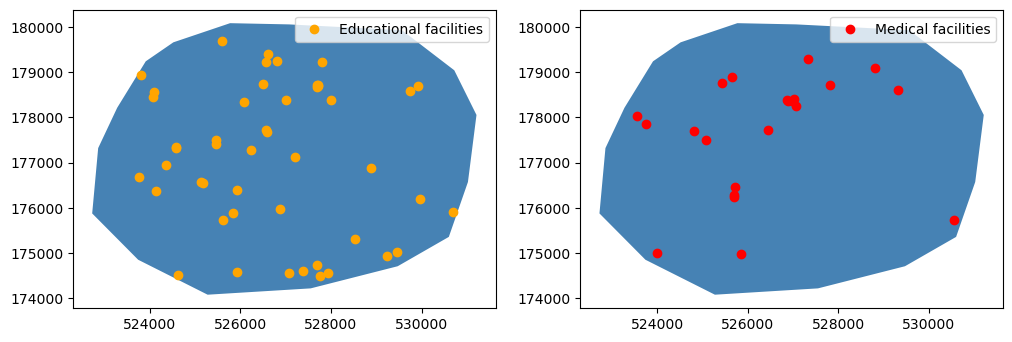

In [8]:
education = facilities[facilities["activity"] == "education"]
medical = facilities[facilities["activity"] == "medical"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

boundary.plot(ax=ax1, color="steelblue")
education.plot(ax=ax1, color="orange", label="Educational facilities")
ax1.legend()

boundary.plot(ax=ax2, color="steelblue")
medical.plot(ax=ax2, color="red", label="Medical facilities")
ax2.legend()

In [9]:
lsoas_clipped.crs = "EPSG:27700"
len(lsoas_clipped)

306

In [10]:
lsoas_clipped = lsoas_clipped.set_index("LSOA_NAME")

In [11]:
# build the sampler
facility_sampler = facility.FacilitySampler(
    facilities=facilities, zones=lsoas_clipped, build_xml=True, fail=False, random_default=True
)

Joining facilities data to zones, this may take a while.


Building sampler, this may take a while.


## Activity generation model

In [12]:
# Create random area sample


def random_area_sampler():
    indexes = list(lsoas_clipped.index)
    return np.random.choice(indexes)


random_area_sampler()  # test

'Hammersmith and Fulham 020A'

- It is a simple home based tours within 24 hours. 
- We create different activity types: work, leisure, education, shopping, etc. Different transport model types: car, bus, subway, etc. 
- Random number is assigned to the duration for each activity and transport mode

In [13]:
# mapping the MSOA and LAD with index
mapping_dict = dict(zip(lsoas_clipped.index, lsoas_clipped.MSOA_CODE))
mapping_dict1 = dict(zip(lsoas_clipped.index, lsoas_clipped.LA_NAME))

In [14]:
# Generate agents in west london area


def generate_agents(no_of_agents):
    """
    Randomly create agents with simple home-based tours.
    The trip starts from home, has a random number of various acitivites, tranport modes would be added.
    The trip finally ends at home.

    """
    population = Population()  # Initialise an empty population

    # Create simple personal attributes
    income = ["low", "medium", "high"]
    gender = ["male", "female"]
    sort_age = [
        "0 to 4",
        "5 to 10",
        "11 to 15",
        "16 to 20",
        "21 to 25",
        "26 to 29",
        "30 to 39",
        "40 to 49",
        "50 to 59",
        "60 to 64",
        "65 to 69",
        "70 to 74",
        "75 to 79",
        "80 to 84",
        "85  and over",
    ]

    # Create mode and activities
    transport = ["car", "bus", "ferry", "rail", "subway", "bike", "walk"]
    # Removed gym and park due to osmox problem
    activity = [
        "leisure",
        "work",
        "shop",
        "medical",
        "education",
        "park",
        "pub",
        "gym",
    ]  # Primary activity
    sub_activity = [
        "shop",
        "medical",
        "pub",
        "gym",
    ]  # People usually spend less time on sub activity

    # Add activity plan for each person
    for i in range(no_of_agents):
        # Create different agents and household
        agent_id = f"agent_{i}"
        hh_id = f"hh_{i}"
        hh = Household(hh_id, freq=1)

        # Adding Activities and Legs alternately to different agents
        # Activity 1 - home
        leaves_home = (np.random.randint(6, 8) * 60) + np.random.randint(0, 100)  # minutes
        location1 = random_area_sampler()
        location1_loc = facility_sampler.sample(location1, "home")
        lsoa_name = mapping_dict.get(location1)
        lad_name = mapping_dict1.get(location1)

        agent = Person(
            agent_id,
            freq=1,
            attributes={
                "subpopulation": np.random.choice(income) + " income",
                "gender": np.random.choice(gender),
                "age": np.random.choice(sort_age),
                "household_zone": location1,
                "household_LSOA": lsoa_name,
                "household_LAD": lad_name,
            },
        )

        hh.add(agent)
        population.add(hh)

        # Trip duration
        trip_duration_main_activity = np.random.randint(3, 6) * 60
        trip_duration_sub_activity = np.random.randint(1, 3) * 60

        agent.add(
            Activity(
                seq=1,
                act="home",
                area=location1,
                loc=location1_loc,
                start_time=mtdt(0),
                end_time=mtdt(leaves_home),
            )
        )

        # Initiated parameters
        location_prev = location1
        location_prev_loc = location1_loc
        leave_time = leaves_home

        # Add random numbers of activities
        no_of_activities = np.random.randint(1, 5)

        for i in range(no_of_activities):
            arrives_primary = leave_time + np.random.randint(10, 90)  # minutes

            # Activity 2.
            if i < 2:  # Start with main activity
                random_act = np.random.choice(activity)
            else:
                random_act = np.random.choice(sub_activity)

            if random_act == ("work"):
                leaves_primary = arrives_primary + trip_duration_main_activity
            else:
                leaves_primary = arrives_primary + trip_duration_sub_activity

            # Outbound leg
            location_next = random_area_sampler()
            location_next_loc = facility_sampler.sample(location_next, random_act)

            agent.add(
                Leg(
                    seq=i + 1,
                    mode=np.random.choice(transport),
                    start_area=location_prev,
                    start_loc=location_prev_loc,
                    end_area=location_next,
                    end_loc=location_next_loc,
                    start_time=mtdt(leave_time),
                    end_time=mtdt(arrives_primary),
                )
            )

            agent.add(
                Activity(
                    seq=i + 2,
                    act=random_act,
                    area=location_next,
                    loc=location_next_loc,
                    start_time=mtdt(arrives_primary),
                    end_time=mtdt(leaves_primary),
                )
            )

            # Update parameters
            leave_time = leaves_primary
            location_prev = location_next
            location_prev_loc = location_next_loc

        # Inbound leg
        arrives_home = leave_time + np.random.randint(10, 90)  # minutes
        agent.add(
            Leg(
                seq=no_of_activities + 1,
                mode=np.random.choice(transport),
                start_area=location_next,
                start_loc=location_next_loc,
                end_area=location1,
                end_loc=location1_loc,
                start_time=mtdt(leave_time),
                end_time=mtdt(arrives_home),
            )
        )

        # Activity
        agent.add(
            Activity(
                seq=no_of_activities + 2,
                act="home",
                area=location1,
                loc=location1_loc,
                start_time=mtdt(arrives_home),
                end_time=END_OF_DAY,
            )
        )

    return population

In [15]:
# Create 100 agents and check the population statistics
population = generate_agents(20)
print(population.stats)

Using random sample for zone:Lambeth 008B:work


Using random sample for zone:Hammersmith and Fulham 022C:pub


Using random sample for zone:Lambeth 013B:shop


Using random sample for zone:Wandsworth 017A:gym


Using random sample for zone:Wandsworth 015E:pub


Using random sample for zone:Wandsworth 003A:leisure


Using random sample for zone:Wandsworth 002C:medical


Using random sample for zone:Hammersmith and Fulham 013C:work


Using random sample for zone:Lambeth 004D:education


Using random sample for zone:Wandsworth 018B:gym


Using random sample for zone:Hammersmith and Fulham 020E:gym


Using random sample for zone:Kensington and Chelsea 015B:gym


Using random sample for zone:Wandsworth 015D:pub


Using random sample for zone:Kensington and Chelsea 008C:medical


Using random sample for zone:Wandsworth 007D:pub


Using random sample for zone:Wandsworth 001D:gym


Using random sample for zone:Kensington and Chelsea 017E:medical


Using random sample for zone:Kensington and Chelsea 017B:shop


Using random sample for zone:Wandsworth 001C:park


Using random sample for zone:Lambeth 017A:education


Using random sample for zone:Hammersmith and Fulham 017C:shop


Using random sample for zone:Wandsworth 009D:leisure


Using random sample for zone:Westminster 024C:pub


Using random sample for zone:Kensington and Chelsea 015B:pub


Using random sample for zone:Wandsworth 006A:gym


Using random sample for zone:Kensington and Chelsea 021A:gym


Using random sample for zone:Lambeth 013B:work


Using random sample for zone:Lambeth 012D:medical


Using random sample for zone:Kensington and Chelsea 014E:pub


Using random sample for zone:Lambeth 007A:work


Using random sample for zone:Hammersmith and Fulham 016D:park


Using random sample for zone:Hammersmith and Fulham 020B:gym


Using random sample for zone:Kensington and Chelsea 009B:shop


Using random sample for zone:Hammersmith and Fulham 023B:pub


Using random sample for zone:Wandsworth 007B:shop


Using random sample for zone:Kensington and Chelsea 015C:pub


Using random sample for zone:Westminster 021A:gym


Using random sample for zone:Hammersmith and Fulham 020C:park


Using random sample for zone:Wandsworth 006C:shop


Using random sample for zone:Kensington and Chelsea 012E:shop


Using random sample for zone:Kensington and Chelsea 015B:shop


Using random sample for zone:Westminster 023A:gym


Using random sample for zone:Kensington and Chelsea 013A:leisure


Using random sample for zone:Wandsworth 019C:park


Using random sample for zone:Hammersmith and Fulham 016D:pub


{'num_households': 20, 'num_people': 20, 'num_activities': 92, 'num_legs': 72}


In [16]:
population.random_person().print()

Person: agent_14
{'subpopulation': 'high income', 'gender': 'male', 'age': '5 to 10', 'household_zone': 'Westminster 023A', 'household_LSOA': 'E02000982', 'household_LAD': 'Westminster'}
0:	Activity(act:home, location:POINT (528674.754749049 178085.52007832748), time:00:00:00 --> 08:24:00, duration:8:24:00)
1:	Leg(mode:car, area:POINT (528674.754749049 178085.52007832748) --> POINT (524366.7278900618 179488.58531248264), time:08:24:00 --> 09:46:00, duration:1:22:00)
2:	Activity(act:shop, location:POINT (524366.7278900618 179488.58531248264), time:09:46:00 --> 11:46:00, duration:2:00:00)
3:	Leg(mode:bike, area:POINT (524366.7278900618 179488.58531248264) --> POINT (527123.1724066776 177645.15136836463), time:11:46:00 --> 13:01:00, duration:1:15:00)
4:	Activity(act:leisure, location:POINT (527123.1724066776 177645.15136836463), time:13:01:00 --> 15:01:00, duration:2:00:00)
5:	Leg(mode:bus, area:POINT (527123.1724066776 177645.15136836463) --> POINT (526077.4308400992 175824.41748798476),

In [17]:
population.random_person().attributes

{'subpopulation': 'high income',
 'gender': 'male',
 'age': '50 to 59',
 'household_zone': 'Hammersmith and Fulham 010D',
 'household_LSOA': 'E02000381',
 'household_LAD': 'Hammersmith and Fulham'}

## Data Visulazation and validation

In [18]:
# Validation if it works
population.validate()

In [19]:
# Print random person activity plan
population.random_person().print()

Person: agent_7
{'subpopulation': 'high income', 'gender': 'female', 'age': '65 to 69', 'household_zone': 'Lambeth 015C', 'household_LSOA': 'E02000632', 'household_LAD': 'Lambeth'}
0:	Activity(act:home, location:POINT (530210.4950919976 175462.92665453235), time:00:00:00 --> 06:59:00, duration:6:59:00)
1:	Leg(mode:ferry, area:POINT (530210.4950919976 175462.92665453235) --> POINT (531028.1389694853 177371.31543672664), time:06:59:00 --> 08:19:00, duration:1:20:00)
2:	Activity(act:shop, location:POINT (531028.1389694853 177371.31543672664), time:08:19:00 --> 09:19:00, duration:1:00:00)
3:	Leg(mode:rail, area:POINT (531028.1389694853 177371.31543672664) --> POINT (530210.4950919976 175462.92665453235), time:09:19:00 --> 10:07:00, duration:0:48:00)
4:	Activity(act:home, location:POINT (530210.4950919976 175462.92665453235), time:10:07:00 --> 00:00:00, duration:13:53:00)


Plot the activities as a 24-hour diary schedules for 5 randomly chosen agents

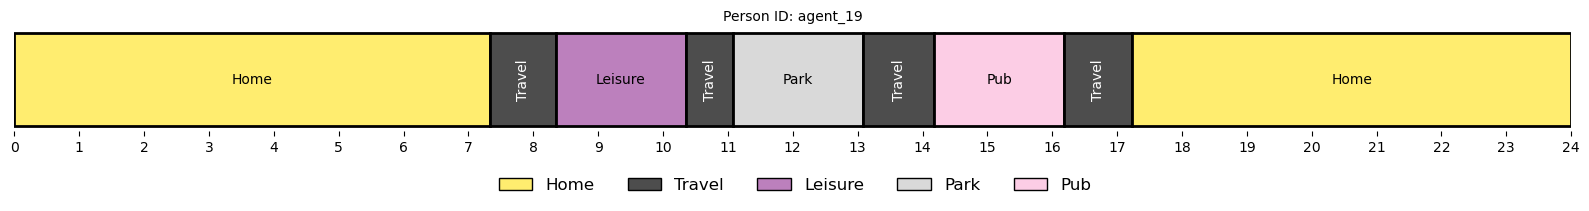

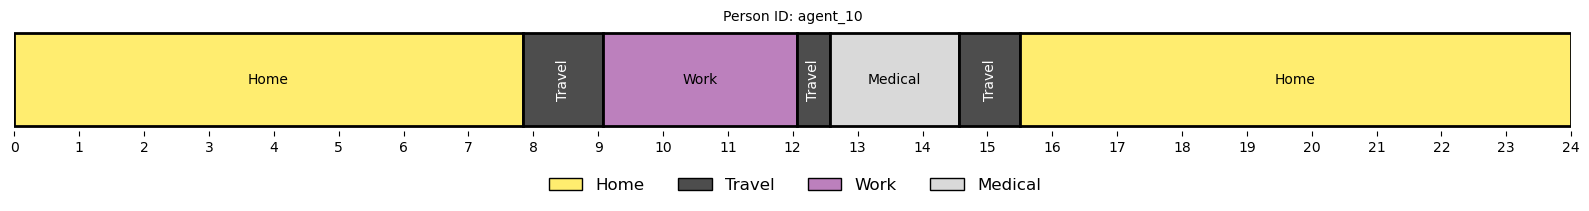

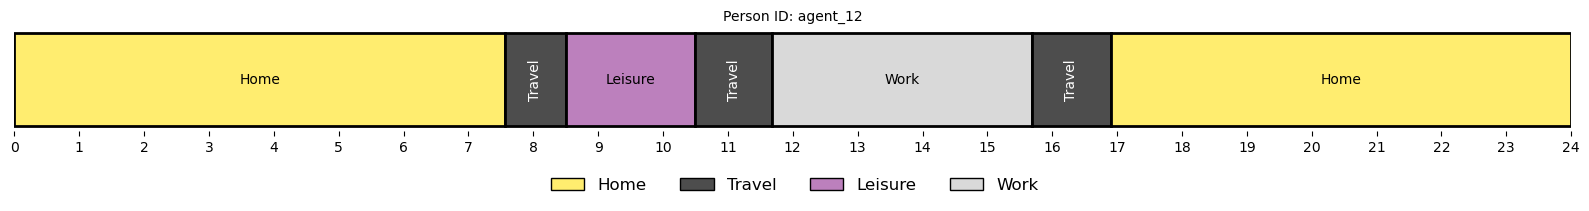

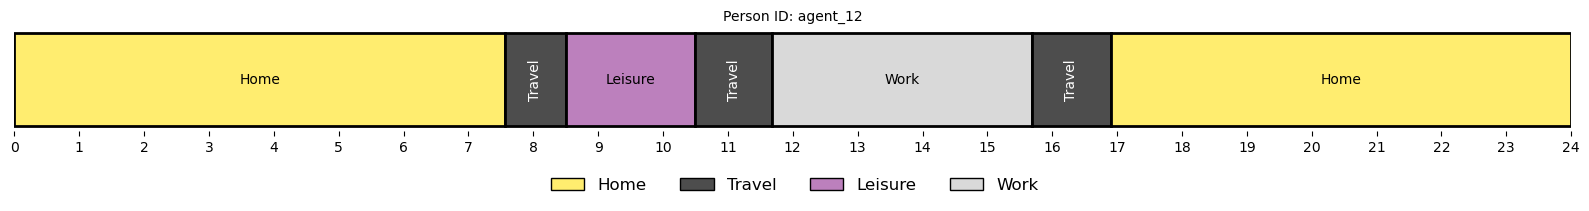

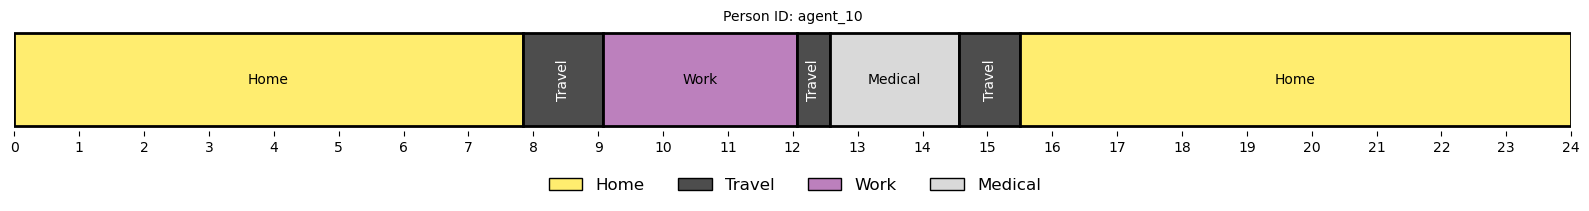

In [20]:
for _i in range(5):
    p = population.random_person()
    p.plot()

Plot the frequency with which each of the activity types happens throughout the 24-hour period.

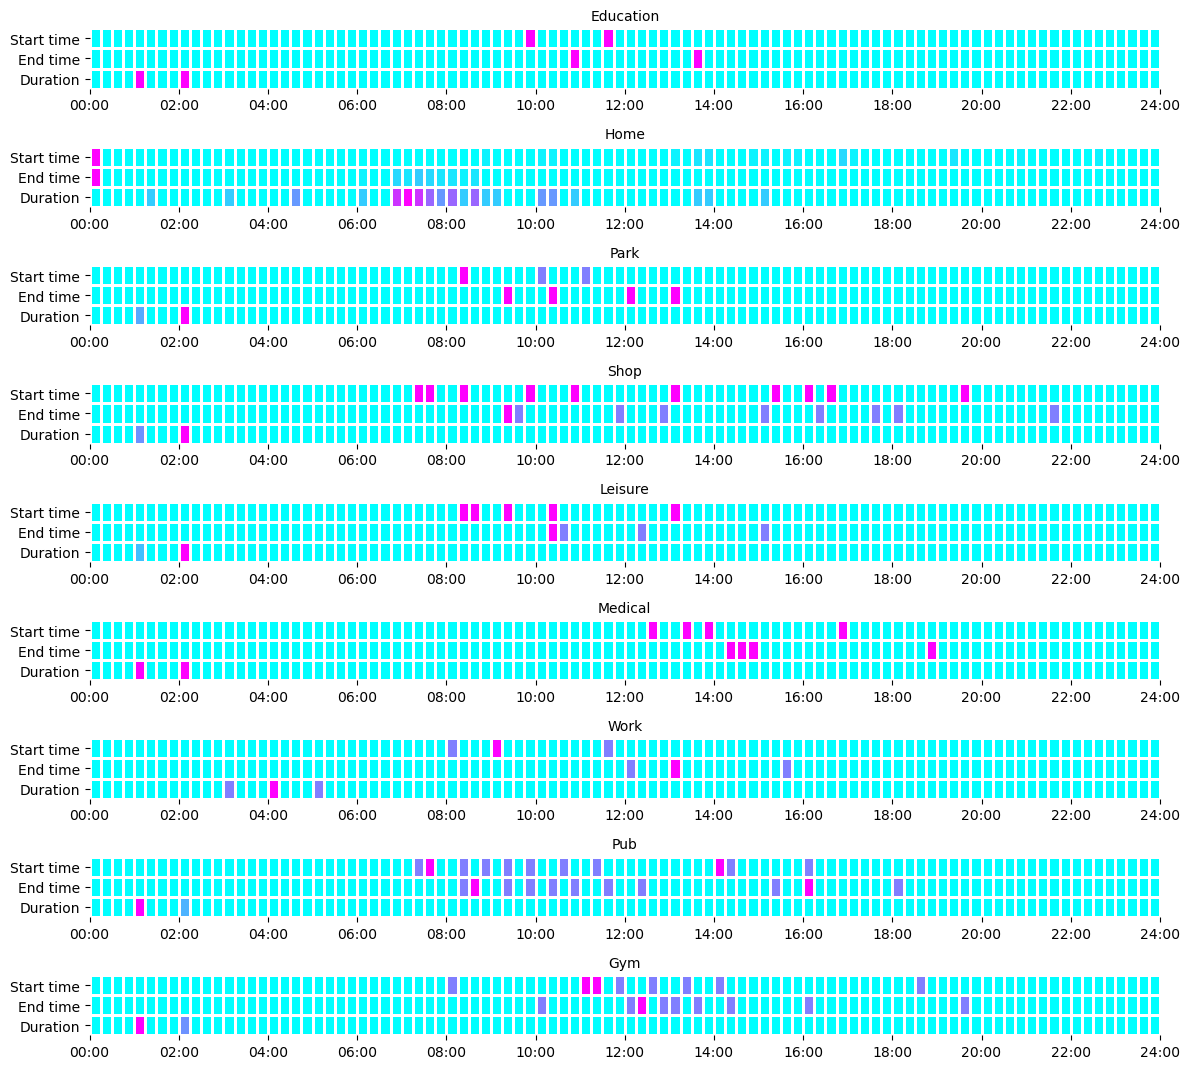

In [21]:
fig = plot_activity_times(population)

In [22]:
# Check the duration of trips
durations = duration_counts(population)
durations

/Users/bryn.pickering/Repos/arup-group/pam/pam/report/benchmarks.py:128: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(dimensions)[data_fields].agg(aggfunc).fillna(0)
/Users/bryn.pickering/Repos/arup-group/pam/pam/report/benchmarks.py:128: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df.groupby(dimensions)[data_fields].agg(aggfunc).fillna(0)


,duration,trips
0,0 to 5 min,0
1,5 to 10 min,0
2,10 to 15 min,3
3,15 to 30 min,5
4,30 to 45 min,11
5,45 to 60 min,10
6,60 to 90 min,43
7,90 to 120 min,0
8,120+ min,0


Now plot a histogram for duration of the trips.

(-0.8400000000000001, 7.0)

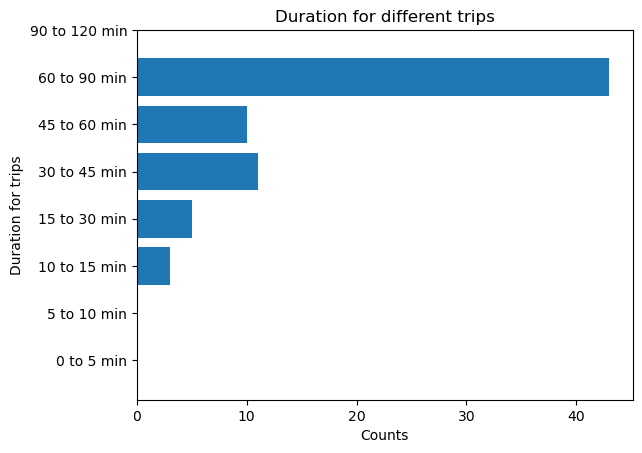

In [23]:
plt.barh(durations["duration"], durations["trips"])
plt.xlabel("Counts")
plt.ylabel("Duration for trips")
plt.title("Duration for different trips")
plt.ylim(ymax="90 to 120 min")

In [24]:
# Check the distance of trips
distances = distance_counts(population)
distances

/Users/bryn.pickering/Repos/arup-group/pam/pam/report/benchmarks.py:128: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(dimensions)[data_fields].agg(aggfunc).fillna(0)
/Users/bryn.pickering/Repos/arup-group/pam/pam/report/benchmarks.py:128: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df.groupby(dimensions)[data_fields].agg(aggfunc).fillna(0)


,distance,trips
0,0 to 1 km,3
1,1 to 5 km,59
2,5 to 10 km,10
3,10 to 25 km,0
4,25 to 50 km,0
5,50 to 100 km,0
6,100 to 200 km,0
7,200+ km,0


Next we plot the distribution of trip distances.

(-0.79, 4.0)

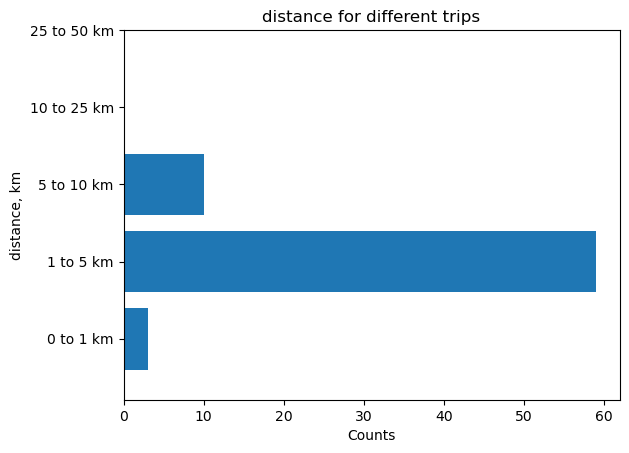

In [25]:
plt.barh(distances["distance"], distances["trips"])
plt.xlabel("Counts")
plt.ylabel("distance, km")
plt.title("distance for different trips")
plt.ylim(ymax="25 to 50 km")

## Read/write data

### Export intermediate CSV tables of population

In [26]:
to_csv(population, dir="outputs", crs="epsg:27700")

Plot the distribution of activities by type

Text(0.5, 1.0, 'activities count')

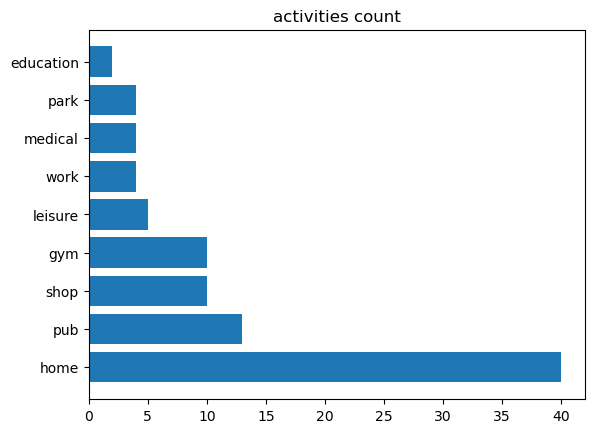

In [27]:
df_activity = pd.read_csv(os.path.join("outputs", "activities.csv"))
totals = df_activity.activity.value_counts()
plt.barh(totals.index, totals)
plt.title("activities count")

In [28]:
write_od_matrices(population, path="outputs")
od_matrices = pd.read_csv(
    os.path.join("outputs", "total_od.csv")
)  # we should change this method to be consistent with other - ie return a dataframe
od_matrices["total origins"] = od_matrices.drop("Origin", axis=1).sum(axis=1)
od_matrices

,Origin,Hammersmith and Fulham 010D,Hammersmith and Fulham 013C,Hammersmith and Fulham 015A,Hammersmith and Fulham 016A,Hammersmith and Fulham 016D,Hammersmith and Fulham 017C,Hammersmith and Fulham 020B,Hammersmith and Fulham 020C,Hammersmith and Fulham 020E,...,Wandsworth 017A,Wandsworth 018B,Wandsworth 018D,Wandsworth 019C,Westminster 019A,Westminster 020D,Westminster 021A,Westminster 023A,Westminster 024C,total origins
0,Hammersmith and Fulham 010D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Hammersmith and Fulham 013C,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,Hammersmith and Fulham 015A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,Hammersmith and Fulham 016A,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,Hammersmith and Fulham 016D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Westminster 019A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
60,Westminster 020D,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
61,Westminster 021A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
62,Westminster 023A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


Plot the number of trips originating from each LSOA

/Users/bryn.pickering/mambaforge/envs/pam/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Text(0.5, 1.0, 'Total Origins')

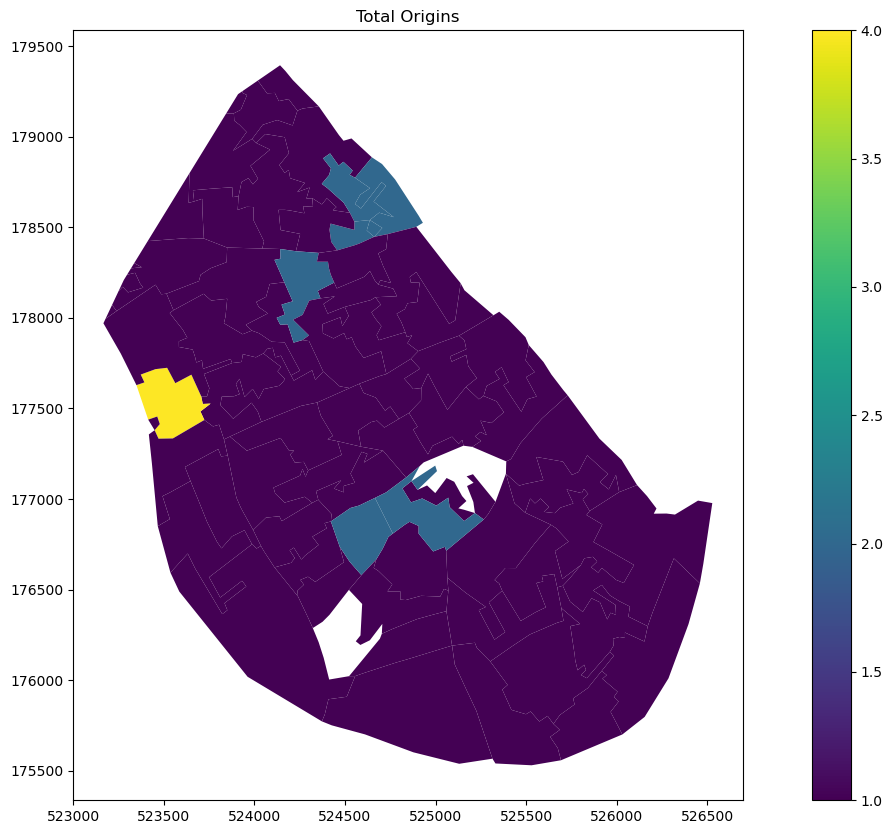

In [29]:
lsoas_clipped = lsoas_clipped.reset_index()
origins_heat_map = lsoas_clipped.join(od_matrices["total origins"])

fig, ax = plt.subplots(figsize=(18, 10))
origins_heat_map.plot("total origins", legend=True, ax=ax)
ax.set_title("Total Origins")

### Reload Tabular Data

We load in the csv files we previously wrote to disk. This replicates a simple synthesis process we might typically use for travel diary survey data.

In [30]:
people = pd.read_csv(os.path.join("outputs", "people.csv")).set_index("pid")
hhs = pd.read_csv(os.path.join("outputs", "households.csv")).set_index("hid")
trips = pd.read_csv(os.path.join("outputs", "legs.csv")).drop(["Unnamed: 0"], axis=1)

trips = trips.rename(columns={"origin activity": "oact", "destination activity": "dact"})
trips.head()

,pid,hid,freq,ozone,dzone,purp,oact,dact,mode,seq,tst,tet,duration
0,agent_0,hh_0,NaN,Lambeth 010B,Lambeth 008B,NaN,home,work,subway,1,1900-01-01 07:45:00,1900-01-01 09:01:00,1:16:00
1,agent_0,hh_0,NaN,Lambeth 008B,Hammersmith and Fulham 022C,NaN,work,pub,bus,2,1900-01-01 13:01:00,1900-01-01 14:27:00,1:26:00
2,agent_0,hh_0,NaN,Hammersmith and Fulham 022C,Lambeth 013B,NaN,pub,shop,car,3,1900-01-01 15:27:00,1900-01-01 16:37:00,1:10:00
3,agent_0,hh_0,NaN,Lambeth 013B,Wandsworth 017A,NaN,shop,gym,car,4,1900-01-01 17:37:00,1900-01-01 18:38:00,1:01:00
4,agent_0,hh_0,NaN,Wandsworth 017A,Lambeth 010B,NaN,gym,home,walk,5,1900-01-01 19:38:00,1900-01-01 20:47:00,1:09:00


In [31]:
population_reloaded = load_travel_diary(trips=trips, persons_attributes=people, hhs_attributes=hhs)

Using from-to activity parser using 'oact' and 'dact' columns


Plot the activities as a 24-hour diary schedules

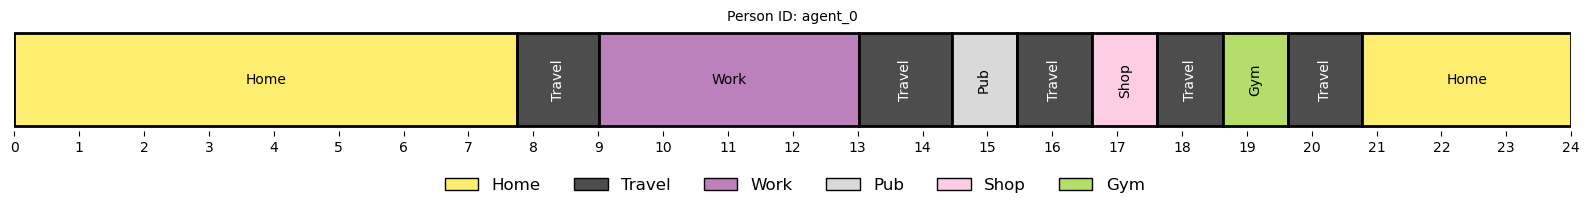

In [32]:
population["hh_0"]["agent_0"].plot()

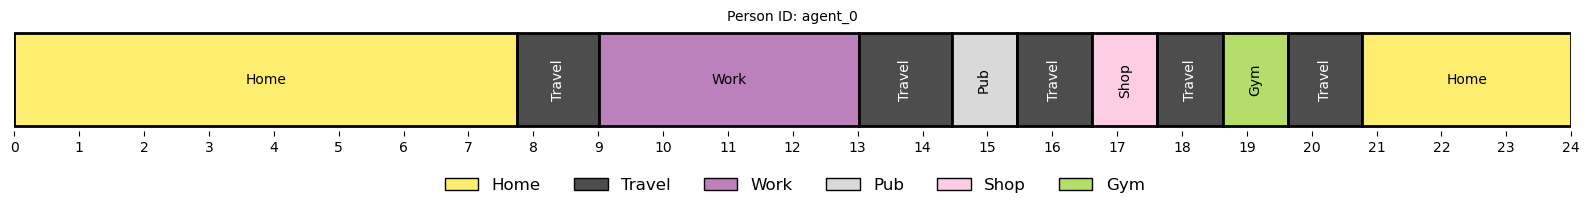

In [33]:
population_reloaded["hh_0"]["agent_0"].plot()

In [34]:
population == population_reloaded

False

The populations are not the same because the csv files did not preserve the coordinates that we previously sampled, so we will sample them again. But the reloaded population will be different as for each location a new coordinate is sampled.

### Write output to MATSim xml

In [35]:
write_matsim(population=population, plans_path=os.path.join("outputs", "population.xml"))